In [1]:
import torch
from Net import TiledAttention, BaseLine , SANModel
import json
import os
import os.path as osp
import torch.nn.functional as F
from VQA_Dataset import VQA_Data
from torch.utils.data import DataLoader
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
vocab_size = 1000
dropout = 0.2
num_classes = vocab_size+1

In [3]:
# Load dict
l_dict = json.load(open('data/vocabulary_1000.json'))
if vocab_size == 3000:
    print('vocab size changed to 3000 .....')
    l_dict = json.load(open('data/vocabulary_alternate.json'))
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
ans_vocab = l_dict['answers']

In [5]:
# Define dataloader
# TODO - Code change for test data loader or is it reqd??
dataset = VQA_Data('train', 1000)
train_dataloader = DataLoader(dataset, batch_size = 1, shuffle=True)

In [6]:
def get_model(model_type):
    # Create model
    if model_type == 'SAN':
        print('Stacked attention model.....')
        model = SANModel(len(l_dict['questions'])+1, dropout, num_classes).to(device)
    elif model_type == 'Baseline':
        print('Baseline model.....')
        model = BaseLine(len(l_dict['questions'])+1, dropout, num_classes).to(device)
    elif model_type == 'Tiled':
        print('Tiled model.....')
        model = TiledAttention(len(l_dict['questions'])+1, dropout, num_classes).to(device)
    return model

In [7]:
def load_model(model, exp_name, best_model):
    exp_path = osp.join('trained_model/', exp_name)
    # Load saved model parameters
    model_path = os.path.join(exp_path, 'models', best_model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [8]:
# baseline
exp_name = 'baseline_0806'
model_type = 'Baseline'
best_model = 'net_9.pth'
model_b = load_model(get_model(model_type), exp_name, best_model)

# baseline
exp_name = 'SAN_Ajit_0806'
model_type = 'SAN'
best_model = 'net_33.pth'
model_s = load_model(get_model(model_type), exp_name, best_model)

# baseline
exp_name = 'tiled_Ajit_0706'
model_type = 'Tiled'
best_model = 'net_24.pth'
model_t = load_model(get_model(model_type), exp_name, best_model)

Baseline model.....
Stacked attention model.....
Tiled model.....


In [9]:
def get_pred(train_dataloader):
    d_batch = next(iter(train_dataloader))
    ques_e = d_batch['quest_e'].squeeze(1).to(device)
    img_e = d_batch['img_e'].squeeze(1).to(device)
    ques_l = d_batch['quest_l']
    ans_e = d_batch['ans_e'].view(-1).to(device)
    img_p = d_batch['img_p']
    ques = d_batch['quest_s']
    ans_s = d_batch['ans_s']

    pred_b = model_b(ques_e, img_e, ques_l)
    pred_b_idx = torch.argmax(pred_b, axis = 1).cpu().numpy()

    pred_s = model_s(ques_e, img_e, ques_l)
    pred_s_idx = torch.argmax(pred_s, axis = 1).cpu().numpy()

    pred_t = model_t(ques_e, img_e, ques_l)
    pred_t_idx = torch.argmax(pred_t, axis = 1).cpu().numpy()
    
    return pred_b_idx, pred_s_idx, pred_t_idx,img_p,ques,ans_s

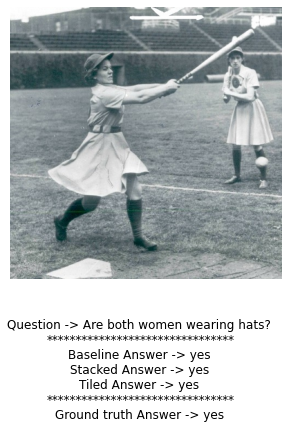

In [27]:
pred_b_idx, pred_s_idx, pred_t_idx,img_p,ques,ans_s = get_pred(train_dataloader)
for i in range(pred_t_idx.shape[0]):
    ques_text = ques[i]
    try:
        pred_ans_b = list(ans_vocab.keys())[list(ans_vocab.values()).index(pred_b_idx[i])]
    except:
        pred_ans_b = 'Not captured'

    try:
        pred_ans_s = list(ans_vocab.keys())[list(ans_vocab.values()).index(pred_s_idx[i])]
    except:
        pred_ans_s = 'Not captured'
    
    try:
        pred_ans_t = list(ans_vocab.keys())[list(ans_vocab.values()).index(pred_t_idx[i])]
    except:
        pred_ans_t = 'Not captured'
        
    gt_ans = ans_s[i]
    txt = 'Question -> %s \n' %(ques_text)
    txt += '********************************\n'
    txt += 'Baseline Answer -> %s \n' %(pred_ans_b)
    txt += 'Stacked Answer -> %s \n' %(pred_ans_s)
    txt += 'Tiled Answer -> %s \n' %(pred_ans_t)
    txt += '********************************\n'
    txt += 'Ground truth Answer -> %s \n' %(gt_ans)

    img = Image.open(img_p[i])
    fig = plt.figure(figsize=(5,5))
    plt.figtext(0.5, -0.3, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print('')